In [3]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = 1


## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('viridis')
%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 0 #2.0
#import seaborn as sns
#sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image

# PyTorch Lightning
import pytorch_lightning as pl
#try:
#    import pytorch_lightning as pl
#except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
#    !pip install --quiet pytorch-lightning>=1.4
#    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
#DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
#CHECKPOINT_PATH = '/home/azamat.kaibaldiyev/Tasmania_ohara_labels/checkpoints_images/'
CHECKPOINT_PATH = '/home/azamat.kaibaldiyev/Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym/'

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

[rank: 0] Global seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda:0
Number of workers: 64


<Figure size 640x480 with 0 Axes>

In [78]:
#all images: from professor
import glob
imgs = sorted(glob.glob('Tasmania_ohara_labels/Ohara_images_from_prof/*/*'))
print(len(imgs))
imgs[:2]

36663


['Tasmania_ohara_labels/Ohara_images_from_prof/i20081006_231255_gtif/PR_20081006_231732_335_LC16.tif',
 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081006_231255_gtif/PR_20081006_231733_335_LC16.tif']

In [79]:
import glob
imgs_new = sorted(glob.glob('Tasmania_ohara_labels/Ohara_images_from_prof_2/*/*'))
print(len(imgs_new))
imgs_new[:2]

20547


['Tasmania_ohara_labels/Ohara_images_from_prof_2/i20081007_033355_gtif/PR_20081007_034607_700_LC16.tif',
 'Tasmania_ohara_labels/Ohara_images_from_prof_2/i20081007_033355_gtif/PR_20081007_034608_701_LC16.tif']

In [80]:
imgs = imgs+imgs_new
print(len(imgs))

57210


In [4]:
bathym =  sorted(glob.glob('Tasmania_ohara_labels/cropped_dems_32/*'))
print(len(bathym))
bathym_labels =  sorted(glob.glob('Tasmania_ohara_labels/cropped_dems_32_with_labels/*'))
print(len(bathym_labels))

100652
10967


In [4]:
bathym[:4]

['Tasmania_ohara_labels/cropped_dems_16/ohara_col1008_row12672.tif',
 'Tasmania_ohara_labels/cropped_dems_16/ohara_col1008_row12688.tif',
 'Tasmania_ohara_labels/cropped_dems_16/ohara_col1008_row12704.tif',
 'Tasmania_ohara_labels/cropped_dems_16/ohara_col1008_row12720.tif']

In [5]:
bathym_labels[:4]

['Tasmania_ohara_labels/cropped_dems_16_with_labels/img0_label5.tiff',
 'Tasmania_ohara_labels/cropped_dems_16_with_labels/img0_label6.tiff',
 'Tasmania_ohara_labels/cropped_dems_16_with_labels/img10000_label4.tiff',
 'Tasmania_ohara_labels/cropped_dems_16_with_labels/img10001_label6.tiff']

In [5]:
bathym_imgs =  sorted(glob.glob('Tasmania_ohara_labels/cropped_dems_16_imgs_100/*'))
print(len(bathym_imgs))


57210


In [30]:
nan_val = np.array(Image.open(bathym_imgs[34000]))[0][0]
if nan_val in np.array(Image.open(bathym_imgs[34000])):
    print('yes')
    print(nan_val)

yes
-3.4028235e+38


In [32]:
print(len(remove_bath_paths))

3523


In [6]:
# Python program to store list to JSON file
import json

# def write_list(a_list):
#     print("Started writing list data into a json file")
#     with open("files_remove_indices/Remove_paths_with_nan_dem16.json", "w") as fp:
#         json.dump(a_list, fp)
#         print("Done writing JSON data into .json file")
# write_list(remove_bath_paths)

# Read list to memory
def read_list():
    # for reading also binary mode is important
    with open('files_remove_indices/Remove_paths_with_nan_dem16.json', 'rb') as fp:
        n_list = json.load(fp)
        return n_list

# assume you have the following list
remove_bath_paths = read_list()
print(len(remove_bath_paths))

3523


In [7]:
bathym_imgs_stay = [ele for ele in bathym_imgs if ele not in remove_bath_paths]
print(len(bathym_imgs_stay))

53687


In [8]:
stay_idxs_imgs = [i for i,ele in enumerate(bathym_imgs) if ele not in remove_bath_paths]
print(len(stay_idxs_imgs))

53687


In [9]:
imgs_to_stay= [ele for i, ele in enumerate(imgs) if i in stay_idxs_imgs]
print(len(imgs_to_stay))

53687


In [45]:
bathym_and_imgs_path = (bathym+list(zip(bathym_imgs_stay,imgs_to_stay[:len(bathym_imgs_stay)])))
bathym_and_imgs_path[-3:]

NameError: name 'bathym' is not defined

In [11]:
bathym_and_imgs_path = list(zip(bathym_imgs_stay,imgs_to_stay[:len(bathym_imgs_stay)]))
print(len(bathym_and_imgs_path))
bathym_and_imgs_path[-3:]


53687


[('Tasmania_ohara_labels/cropped_dems_16_imgs_100/PR_20081014_072452_820_LC16.tif',
  'Tasmania_ohara_labels/Ohara_images_from_prof_2/i20081014_052323_gtif/PR_20081014_072452_820_LC16.tif'),
 ('Tasmania_ohara_labels/cropped_dems_16_imgs_100/PR_20081014_072453_817_LC16.tif',
  'Tasmania_ohara_labels/Ohara_images_from_prof_2/i20081014_052323_gtif/PR_20081014_072453_817_LC16.tif'),
 ('Tasmania_ohara_labels/cropped_dems_16_imgs_100/PR_20081014_072454_816_LC16.tif',
  'Tasmania_ohara_labels/Ohara_images_from_prof_2/i20081014_052323_gtif/PR_20081014_072454_816_LC16.tif')]

In [43]:
bathym_and_imgs_path

('Tasmania_ohara_labels/cropped_dems_16_imgs_100/PR_20081008_234322_688_LC16.tif',
 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081008_224114_gtif/PR_20081008_234322_688_LC16.tif')

from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=0)
for i, (train_index, test_index) in enumerate(rs.split(dataset)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [7]:
# with open('files_remove_indices/Ohara_dems_and_images_137000_labels_train_set_indexes.npy', 'wb') as f:
#     np.save(f, train_index)

# with open('files_remove_indices/Ohara_dems_and_images_137000_labels_test_set_indexes.npy', 'wb') as f:
#     np.save(f, test_index)

with open('files_remove_indices/Ohara_dems_and_images_137000_labels_train_set_indexes.npy', 'rb') as f:
    train_set_indexes = np.load(f)

with open('files_remove_indices/Ohara_dems_and_images_137000_labels_test_set_indexes.npy', 'rb') as f:
    test_set_indexes = np.load(f)
    
print(len(train_set_indexes))
print(len(test_set_indexes))

119884
13321


In [2]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import glob
import rasterio

dem_size = 32

class SwedishDataset(Dataset):
    def __init__(self,  transform  = None, dataset_path = None, remove_list = None, labels = False):
        self.imgs_path = dataset_path
        
        if labels:
            self.file_list_dem = df_merged_images['Left image name']

        self.transform = transform
        self.labels = labels
        
    def __len__(self):
        return len(self.imgs_path)

          
    def __getitem__(self, idx):
        img_path_dem = self.imgs_path[idx]
        if len(img_path_dem)==2:
            dem_raster = Image.open(img_path_dem[0])
            img_raster = np.array(Image.open(img_path_dem[1]))[:,:,0]
            dem_raster = dem_transforms(dem_raster)
            img_raster = img_transforms(img_raster)
            img_raster_dem = [dem_raster, img_raster]
        else:
            img_raster_dem = Image.open(img_path_dem)
            img_raster_dem = self.transform(img_raster_dem)
        if self.labels:
            label = int(df_merged_images['cluster_id'][idx])
        else:
            label = 'no_label'
        
        return [img_raster_dem, label]
    

def normalize_input_for_dem(test_iter):
    #test_iter = torch.from_numpy(test_iter)
    input_images = test_iter.float()
    maxv = 104
    minv = 5
#     batch_size = input_images.shape[0]
#     cmin = torch.amin(input_images,(1,2)).reshape((batch_size,1,1))
#     cmax = torch.amax(input_images,(1,2)).reshape((batch_size,1,1))
    return (input_images-minv)/(maxv-minv) #(input_images-cmin)/(cmax-cmin)

class Normalize_range01:
    #bring to range 0 to 1

    def __init__(self, p=1):
        self.p = 1

    def __call__(self, x):
        result = normalize_input_for_dem(x)
        return result

    def __repr__(self):
        return "custom augmentation"

    
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]
    
    


contrast_transforms = transforms.Compose([transforms.ToTensor(),
                                          Normalize_range01(),
                                          transforms.Resize(size = dem_size),
                                          #Normalize_range01(),
                                          #transforms.ToPILImage(), 
                                          #transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=dem_size),
                                          #transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
                                          #transforms.RandomGrayscale(p=0.2),
                                          #transforms.GaussianBlur(kernel_size=9),
                                          #transforms.ToTensor(),
                                          #transforms.Normalize((0.5,), (0.5,))
                                          
                                         ])

dem_transforms = transforms.Compose([transforms.ToTensor(),
                                    Normalize_range01(),
                                    transforms.Resize(size = dem_size),
                                    transforms.RandomResizedCrop(size=dem_size),
                                    #transforms.Normalize((0.5,), (0.5,))
                                    #Normalize_range01()
                                    ])

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(size = 100),
                                     transforms.RandomResizedCrop(size=dem_size),
                                     #transforms.Normalize((0.5,), (0.5,))
                                     ])



from torch.utils.data import random_split
import math
dataset_path = imgs# bathym_and_imgs_path
dataset = SwedishDataset(transform = ContrastiveTransformations(contrast_transforms, n_views = 2), dataset_path = dataset_path)

print(len(dataset))
dataset_len =len(dataset)

from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=0)
for i, (train_index, test_index) in enumerate(rs.split(dataset)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

train_set_indexes = train_index
test_set_indexes = test_index

train_dataset = torch.utils.data.Subset(dataset, train_set_indexes)
test_dataset = torch.utils.data.Subset(dataset, test_set_indexes)

print(len(train_dataset))
print(len(test_dataset))

NameError: name 'imgs' is not defined

In [81]:
import pandas as pd
df_labels =  pd.read_csv('Tasmania_ohara_labels/image_labels.data',skiprows = np.arange(15),sep = "\t")
                    #names = ['row_id','timestamp','left_image','right_image','cluster_id'], )
df_labels.rename(columns = {'left_image':'Left image name', 'right_image':'Right image name'}, inplace = True)
df_labels['Left image name'] = df_labels['Left image name'].str.split('.').str[0].str.strip()+'.tif'
df_labels['Right image name'] = df_labels['Right image name'].str.strip()
df_labels[-2:]

,row_id,timestamp,Left image name,Right image name,cluster_id
10965,11276,1.223432e+09,PR_20081008_021104_665_LC16.tif,PR_20081008_021104_665_RM16.png,6
10966,11277,1.223432e+09,PR_20081008_021105_662_LC16.tif,PR_20081008_021105_662_RM16.png,6


In [82]:
df_images = pd.DataFrame(imgs, columns =['Left image name'])
df_images['Left image name'] = df_images['Left image name'].str.split('/').str[-1]
df_images[-2:]

,Left image name
57208,PR_20081014_072453_817_LC16.tif
57209,PR_20081014_072454_816_LC16.tif


In [83]:
df_merged_images = pd.merge(df_labels, df_images, on = 'Left image name')
df_merged_images['Left image name'] = 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081007_224547_gtif/'+df_merged_images['Left image name']
df_merged_images['cluster_id'] = df_merged_images['cluster_id'].replace([1, 2, 3 ,4,5, 6, 7, 8], [0, 1, 2, 3 ,4,5, 6, 7])
df_merged_images[-2:]

,row_id,timestamp,Left image name,Right image name,cluster_id
10965,11276,1.223432e+09,Tasmania_ohara_labels/Ohara_images_from_prof/i...,PR_20081008_021104_665_RM16.png,5
10966,11277,1.223432e+09,Tasmania_ohara_labels/Ohara_images_from_prof/i...,PR_20081008_021105_662_RM16.png,5


In [4]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import glob
import rasterio
dataset_path_images = 'Tasmania_ohara_labels/Ohara_images_from_prof/*/'
dataset_path_images_labels = 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/'

dataset_path_bathym = 'Tasmania_ohara_labels/cropped_dems_16/'
dataset_path_bathym_labels = 'Tasmania_ohara_labels/cropped_dems_16_with_labels/'

# dataset_path_bathym = 'Tasmania_ohara_labels/cropped_dems_32/'
# dataset_path_bathym_labels = 'Tasmania_ohara_labels/cropped_dems_32_with_labels/'

dem_size = 16

class SwedishDataset(Dataset):
    def __init__(self,  transform  = None, dataset_path = None, remove_list = None, labels_dems=False,
                 labels_imgs = False, for_imgs = False):
        
        self.imgs_path = sorted(glob.glob(dataset_path+'*'))
        if for_imgs:
            self.imgs_path = dataset_path
        
        if labels_imgs:
            self.imgs_path = df_merged_images['Left image name']

        self.transform = transform
        self.labels_imgs = labels_imgs
        self.labels_dems = labels_dems
        self.for_imgs = for_imgs
        
    def __len__(self):
        return len(self.imgs_path)

          
    def __getitem__(self, idx):
        img_path_dem = self.imgs_path[idx]
        if len(img_path_dem)==2:
            dem_raster = Image.open(img_path_dem[0])
            img_raster = np.array(Image.open(img_path_dem[1]))[:,:,0]
            dem_raster = dem_transforms(dem_raster)
            img_raster = img_transforms(img_raster)
            img_raster_dem = [dem_raster, img_raster]
        elif self.for_imgs:
            img_raster = np.array(Image.open(img_path_dem))[:,:,0]
            img_raster_dem = self.transform(img_raster)
        else:
            img_raster_dem = Image.open(img_path_dem)
            img_raster_dem = self.transform(img_raster_dem)
            
        
        if self.labels_imgs:
            label = int(df_merged_images['cluster_id'][idx])
        elif self.labels_dems:
            label = int(img_path_dem[-6])
        else:
            label = 'no_label'
            
#         if self.imgs_path==dataset_path_bathym_labels:
#             label = int(self.file_list_dem[idx][-6])
        
        return [img_raster_dem, label]
    
    
    
    
    
def normalize_input_for_dem(test_iter):
    #test_iter = torch.from_numpy(test_iter)
    input_images = test_iter.float()
    maxv = 104
    minv = 5
#     batch_size = input_images.shape[0]
#     cmin = torch.amin(input_images,(1,2)).reshape((batch_size,1,1))
#     cmax = torch.amax(input_images,(1,2)).reshape((batch_size,1,1))
    return (input_images-minv)/(maxv-minv) #(input_images-cmin)/(cmax-cmin)

class Normalize_range01:
    #bring to range 0 to 1

    def __init__(self, p=1):
        self.p = 1

    def __call__(self, x):
        result = normalize_input_for_dem(x)
        return result

    def __repr__(self):
        return "custom augmentation"
    
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]
    
    


contrast_transforms = transforms.Compose([transforms.ToTensor(),
                                          Normalize_range01(),
                                          transforms.Resize(size = dem_size),
                                          #Normalize_range01(),
                                          #transforms.ToPILImage(), 
                                          #transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=dem_size),
                                          #transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
                                          #transforms.RandomGrayscale(p=0.2),
                                          #transforms.GaussianBlur(kernel_size=9),
                                          #transforms.ToTensor(),
                                          #transforms.Normalize((0.5,), (0.5,))
                                          
                                         ])

dem_transforms = transforms.Compose([transforms.ToTensor(),
                                     Normalize_range01(),
                                    transforms.Resize(size = dem_size),
                                    transforms.RandomResizedCrop(size=dem_size),
                                    #transforms.Normalize((0.5,), (0.5,))
                                    ])

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(size = 100),
                                     transforms.RandomResizedCrop(size=dem_size),
                                     #transforms.Normalize((0.5,), (0.5,))
                                     ])



from torch.utils.data import random_split
import math
dataset_path = bathym_and_imgs_path
dataset = SwedishDataset(transform = ContrastiveTransformations(contrast_transforms, n_views = 2), dataset_path = dataset_path)

print(len(dataset))
dataset_len =len(dataset)

train_dataset = torch.utils.data.Subset(dataset, train_set_indexes)
test_dataset = torch.utils.data.Subset(dataset, test_set_indexes)
# train_dataset = torch.utils.data.Subset(dataset, np.arange(100))
# test_dataset = torch.utils.data.Subset(dataset, np.arange(100))
print(len(train_dataset))
print(len(test_dataset))

#print(dataset[4][0][0].shape)
#dataset[4][1].shape


NameError: name 'bathym_and_imgs_path' is not defined

In [9]:
dataset_path[-2:]

[('Tasmania_ohara_labels/cropped_dems_16_imgs_100/PR_20081010_000331_192_LC16.tif',
  'Tasmania_ohara_labels/Ohara_images_from_prof/i20081009_215637_gtif/PR_20081010_000331_192_LC16.tif'),
 ('Tasmania_ohara_labels/cropped_dems_16_imgs_100/PR_20081010_000332_192_LC16.tif',
  'Tasmania_ohara_labels/Ohara_images_from_prof/i20081009_215637_gtif/PR_20081010_000332_192_LC16.tif')]

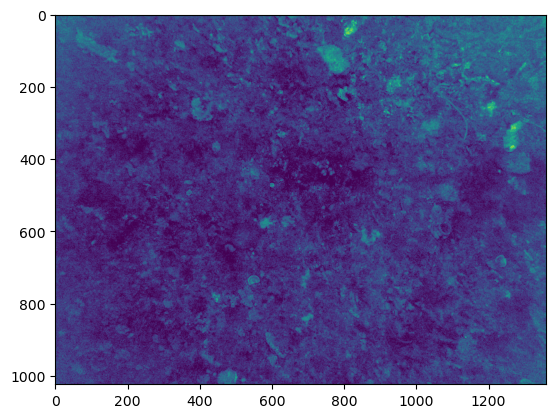

In [10]:
plt.imshow(np.array(Image.open(dataset_path[-1][1]))[:,:,0])

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


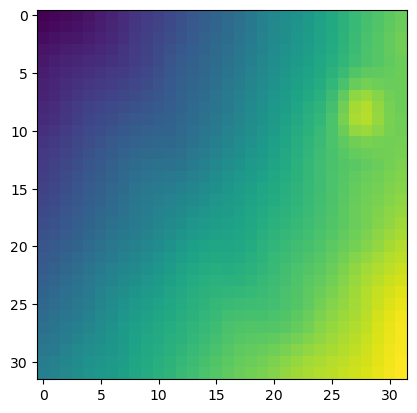

In [11]:
plt.imshow(dataset[0][0][0][0])

In [27]:
dataset[-1][0]

[tensor([[[0.4440, 0.4452, 0.4478,  ..., 0.3061, 0.3060, 0.3090],
          [0.4503, 0.4505, 0.4512,  ..., 0.3074, 0.3048, 0.3067],
          [0.4537, 0.4530, 0.4524,  ..., 0.3072, 0.3034, 0.3043],
          ...,
          [0.4738, 0.4716, 0.4701,  ..., 0.3964, 0.3916, 0.3899],
          [0.4785, 0.4755, 0.4738,  ..., 0.3956, 0.3904, 0.3882],
          [0.4837, 0.4809, 0.4794,  ..., 0.3939, 0.3888, 0.3862]]]),
 tensor([[[0.0134, 0.0091, 0.0472,  ..., 0.1011, 0.1025, 0.1055],
          [0.0196, 0.0120, 0.0213,  ..., 0.0796, 0.1142, 0.1019],
          [0.0304, 0.0595, 0.0355,  ..., 0.0732, 0.0900, 0.1077],
          ...,
          [0.0314, 0.0471, 0.0568,  ..., 0.0643, 0.0674, 0.0774],
          [0.0434, 0.0364, 0.0403,  ..., 0.0462, 0.0666, 0.0583],
          [0.0480, 0.0965, 0.0511,  ..., 0.0554, 0.0522, 0.0701]]])]

In [23]:
dataset[-1][0]

[tensor([[[0.4014, 0.3966, 0.3871,  ..., 0.3402, 0.3417, 0.3425],
          [0.4004, 0.3957, 0.3861,  ..., 0.3399, 0.3415, 0.3422],
          [0.3948, 0.3899, 0.3803,  ..., 0.3383, 0.3398, 0.3405],
          ...,
          [0.3743, 0.3713, 0.3654,  ..., 0.3263, 0.3264, 0.3264],
          [0.3734, 0.3704, 0.3643,  ..., 0.3268, 0.3268, 0.3268],
          [0.3732, 0.3702, 0.3641,  ..., 0.3269, 0.3269, 0.3269]]]),
 tensor([[[0.1608, 0.1451, 0.1255,  ..., 0.1098, 0.1098, 0.1137],
          [0.1529, 0.1412, 0.1294,  ..., 0.1059, 0.1216, 0.1333],
          [0.1216, 0.1216, 0.1176,  ..., 0.1059, 0.1294, 0.1490],
          ...,
          [0.0863, 0.0902, 0.0941,  ..., 0.1020, 0.0980, 0.0941],
          [0.0902, 0.0902, 0.0941,  ..., 0.1255, 0.1255, 0.1216],
          [0.0863, 0.0902, 0.0902,  ..., 0.1255, 0.1294, 0.1294]]])]

In [47]:
dataset[130000][0]

('Tasmania_ohara_labels/cropped_dems_16_imgs_100/PR_20081008_234322_688_LC16.tif', 'Tasmania_ohara_labels/Ohara_images_from_prof/i20081008_224114_gtif/PR_20081008_234322_688_LC16.tif')


[tensor([[[-3.4372e+36, -3.4372e+36, -3.4372e+36,  ..., -3.4372e+36,
           -3.4372e+36, -3.4372e+36],
          [-3.4372e+36, -3.4372e+36, -3.4372e+36,  ..., -3.4372e+36,
           -3.4372e+36, -3.4372e+36],
          [-3.4372e+36, -3.4372e+36, -3.4372e+36,  ..., -3.4372e+36,
           -3.4372e+36, -3.4372e+36],
          ...,
          [-3.4372e+36, -3.4372e+36, -3.4372e+36,  ..., -3.4372e+36,
           -3.4372e+36, -3.4372e+36],
          [-3.4372e+36, -3.4372e+36, -3.4372e+36,  ..., -3.4372e+36,
           -3.4372e+36, -3.4372e+36],
          [-3.4372e+36, -3.4372e+36, -3.4372e+36,  ..., -3.4372e+36,
           -3.4372e+36, -3.4372e+36]]]),
 tensor([[[0.2007, 0.2807, 0.2881,  ..., 0.4569, 0.4552, 0.4592],
          [0.1308, 0.2271, 0.2631,  ..., 0.4571, 0.4946, 0.5895],
          [0.1223, 0.2250, 0.2086,  ..., 0.4954, 0.4747, 0.4733],
          ...,
          [0.3137, 0.3252, 0.3486,  ..., 0.4609, 0.4196, 0.4777],
          [0.3653, 0.3619, 0.3374,  ..., 0.4505, 0.4551, 0.42

# Model

In [11]:
!wandb login --relogin "40706c6c21e200af3bdb3840883f22e665e74441"

wandb: Appending key for api.wandb.ai to your netrc file: /home/azamat.kaibaldiyev/.netrc


In [7]:
import wandb
import random
from sklearn.metrics import classification_report

epochs = 300
lr = 1e-5
#wandb.init(settings=wandb.Settings(start_method="fork"))
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Contrastive_SimCLR_Ohara",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "SimCLR",
    "dataset": "Ohara_dataset_dems_and_images_137000",
    "epochs": epochs,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kaibaldiyev (self-sup-segm). Use `wandb login --relogin` to force relogin


Problem at: /tmp/ipykernel_3098233/888923671.py 9 <module>


KeyboardInterrupt: 

In [40]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        #model = torchvision.models.resnet18()
        num_input_channel = 1
        self.convnet.conv1 = nn.Conv2d(num_input_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        wandb.log({'SimCLR_'+mode+'_loss':nll})
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        wandb.log({'SimCLR_'+mode+'_acc_top1':(sim_argsort == 0).float().mean()})
        wandb.log({'SimCLR_'+mode+'_acc_top5':(sim_argsort < 5).float().mean()})
        wandb.log({'SimCLR_'+mode+'_acc_mean_pos': 1+sim_argsort.float().mean()})
        
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')
        
    def forward(self, x):
        return self.convnet(x)
        
    

In [41]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(log_every_n_steps=10, default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=2)
        val_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=2)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [42]:
simclr_model = train_simclr(batch_size=512,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=2)

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/azamat.kaibaldiyev/miniconda3/envs/contrastive ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Global seed set to 42
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/azamat.kaibaldiyev/miniconda3/envs/contrastive ...
  rank_z

Sanity Checking: 0it [00:00, ?it/s]

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tens

Training: 0it [00:00, ?it/s]

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

Validation: 0it [00:00, ?it/s]

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

# Downstream Task

In [12]:
!wandb login --relogin "40706c6c21e200af3bdb3840883f22e665e74441"

wandb: Appending key for api.wandb.ai to your netrc file: /home/azamat.kaibaldiyev/.netrc


In [99]:
import wandb
import random
from sklearn.metrics import classification_report

epochs = 300
lr = 1e-5
#wandb.init(settings=wandb.Settings(start_method="fork"))
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Contrastive_SimCLR_Ohara",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Downstream_Logreg",
    "dataset": "Ohara_dataset_images_53000_bath_and_imgs",
    "epochs": epochs,
    }
)

Downstream_test_acc,▃▃▃▅▄▃▅▃▅█▄▂▂▇▄▇▅▂▅▇▄▃▄▆▄▁▂▂▃▅▅▂▅▄▅▆▂▅▂▃
Downstream_test_learningrate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Downstream_test_loss,▇▄▄▄▄▆▂▅▃▁▆▆▇▃▄▄▃▆▄▂▅▅▅▂▆▅█▇▄▄▃▆▄▅▄▄▆▅▇▅
Downstream_train_acc,▁▂▂▄▃▆▅▄▅▅▇▄▆▆▆█▆▆▅▆▆▇▇▇▇▅▆▆▇▆█▆▇▇▆▆▇▆▆▇
Downstream_train_learningrate,██████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Downstream_train_loss,█▇▇▆▇▅▅▅▄▄▃▄▄▂▃▂▃▃▃▂▃▁▂▂▂▄▂▂▂▂▁▃▁▂▃▂▂▂▂▁
Downstream_val_acc,▂▂▅▁▄▅▇▆▇▆▇▅▆▇█▇██▇▅▆▇▇▇█▆▇▅▇▇▇▇▇▆▇▅▅▇▇▆
Downstream_val_learningrate,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Downstream_val_loss,██▆█▇▅▅▅▃▃▃▄▄▂▂▂▁▁▁▃▃▂▁▂▁▂▁▃▂▂▁▂▁▂▁▃▃▂▁▂
Downstream_test_acc,0.8913
Downstream_test_learningrate,0.0


In [6]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=300):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        #self.model = nn.Linear(feature_dim, num_classes)
        self.model = nn.Sequential(
                        nn.Linear(feature_dim, num_classes),
                      )
        

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.3),
                                                                  int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        #criterion = F.cross_entropy()
        
        feats, labels = batch
        preds = self.model(feats)
        #print('preds', preds)
        #print('labels:', labels)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        wandb.log({'Downstream_' + mode+'_loss': loss})
        wandb.log({'Downstream_' + mode+'_acc': acc})
        
        lightning_optimizer = self.optimizers()  # self = your model
        current_lr = lightning_optimizer.optimizer.param_groups[0]['lr']
        wandb.log({'Downstream_' + mode+'_learningrate': current_lr})

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [7]:

# with open('files_remove_indices/Ohara_images_11000_labels_train_set_indexes.npy', 'rb') as f:
#     train_set_indexes_labels = np.load(f)

# with open('files_remove_indices/Ohara_images_11000_labels_test_set_indexes.npy', 'rb') as f:
#     test_set_indexes_labels = np.load(f)
    
    
with open('files_remove_indices/Ohara_labels_train_set_indexes.npy', 'rb') as f:
    train_set_indexes_labels = np.load(f)

with open('files_remove_indices/Ohara_labels_test_set_indexes.npy', 'rb') as f:
    test_set_indexes_labels = np.load(f)
    

    
print(len(train_set_indexes_labels))
print(len(test_set_indexes_labels))

9321
1646


In [100]:
#dataset_path_images_labels = 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/'
dataset_path_bathym_labels = 'Tasmania_ohara_labels/cropped_dems_16_with_labels_correct/'
# dataset_path_bathym_labels = 'Tasmania_ohara_labels/cropped_dems_32_with_labels/'

#for optical imgages
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(size = (100,100)),
                                     ##Normalize_range01(),
                                     ##transforms.Normalize((0.5,), (0.5,))
                                    ])
dataset_path_with_labels= dataset_path_bathym_labels
dataset = SwedishDataset(transform = img_transforms , dataset_path=dataset_path_with_labels ,
                         labels_imgs = True, labels_dems = True, for_imgs = False)


#for dem
# img_transforms = transforms.Compose([transforms.ToTensor(),
#                                      Normalize_range01(),
#                                      ##transforms.Normalize((0.5,), (0.5,))
#                                      ])
# dataset_path_with_labels= dataset_path_bathym_labels
# dataset = SwedishDataset(transform = img_transforms , dataset_path=dataset_path_with_labels ,
#                          labels_imgs = True, labels_dems = True, for_imgs = False)


#For random split
# train_dataset = torch.utils.data.Subset(dataset, train_set_indexes_labels)
# test_dataset = torch.utils.data.Subset(dataset, test_set_indexes_labels)

#For different lines
dim = 4460
train_dataset = torch.utils.data.Subset(dataset, np.arange(dim))
test_dataset = torch.utils.data.Subset(dataset, np.arange(dim, len(dataset)))

print(len(dataset))
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))

10967
Number of training examples: 4460
Number of test examples: 6507


In [101]:
print(dataset[0][0].shape)
dataset[999]

torch.Size([3, 100, 100])


[tensor([[[0.2462, 0.2646, 0.3423,  ..., 0.3147, 0.4934, 0.4655],
          [0.3103, 0.3967, 0.3745,  ..., 0.3151, 0.3342, 0.3506],
          [0.2069, 0.2951, 0.3273,  ..., 0.2816, 0.2925, 0.3296],
          ...,
          [0.3655, 0.1879, 0.2014,  ..., 0.5598, 0.5736, 0.4611],
          [0.6016, 0.2690, 0.2383,  ..., 0.4003, 0.4338, 0.4097],
          [0.4672, 0.3732, 0.2518,  ..., 0.4552, 0.3008, 0.4429]],
 
         [[0.2104, 0.3320, 0.3733,  ..., 0.2900, 0.3732, 0.4455],
          [0.2328, 0.3484, 0.3784,  ..., 0.2823, 0.2949, 0.3461],
          [0.2502, 0.2576, 0.3933,  ..., 0.2700, 0.2817, 0.2966],
          ...,
          [0.3226, 0.1523, 0.2386,  ..., 0.5000, 0.5247, 0.4576],
          [0.4837, 0.2003, 0.2504,  ..., 0.4135, 0.4105, 0.3797],
          [0.5093, 0.2888, 0.2569,  ..., 0.4413, 0.2753, 0.3335]],
 
         [[0.2716, 0.3508, 0.3524,  ..., 0.3022, 0.2838, 0.3703],
          [0.2713, 0.3741, 0.3129,  ..., 0.2569, 0.2354, 0.3208],
          [0.2493, 0.2753, 0.3684,  ...,

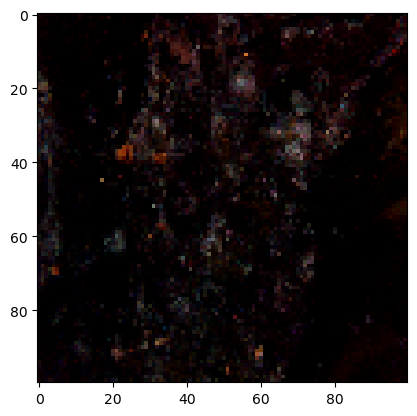

In [102]:
plt.imshow(dataset[0][0].permute(1,2,0))

In [9]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=32, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    #labels, idxs = labels.sort()
    #feats = feats[idxs]
    #mycode
    feats = torch.squeeze(feats)
    labels = torch.squeeze(labels)

    return data.TensorDataset(feats, labels)

In [25]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        #model = torchvision.models.resnet18()
        num_input_channel = 1
        self.convnet.conv1 = nn.Conv2d(num_input_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
     
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')
        
    def forward(self, x):
        return self.convnet(x)
        
    

In [11]:
#DEM16
!ls Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym16_pairs_and_nonpairs/SimCLR/lightning_logs/version_1379899/checkpoints/epoch=25-step=7150.ckpt
#!stat Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym16_only_pairs/SimCLR/lightning_logs/version_1379899/checkpoints/epoch=25-step=7150.ckpt

'epoch=25-step=7150.ckpt'


In [15]:
#DEM32
!ls Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym32_pairs_and_nonpairs/SimCLR/lightning_logs/version_1379898/checkpoints/
#!stat Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym32_only_pairs/SimCLR/lightning_logs/version_1373056/checkpoints/epoch=16-step=3978.ckpt

'epoch=33-step=9180.ckpt'


In [26]:

chkpnt = 'checkpoints_Ohara_images_and_bathym32_pairs_and_nonpairs/SimCLR/lightning_logs/version_1379898/checkpoints/epoch=33-step=9180.ckpt'
best_checkpoint = '/home/azamat.kaibaldiyev/Tasmania_ohara_labels/' +chkpnt
simclr_model = SimCLR.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
simclr_model.eval()
simclr_model.to(device)

SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# DoubleNET

In [92]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        
        # Base model1 f(.)
        self.convnet_dem = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        #model = torchvision.models.resnet18()
        num_input_channel_dem = 1
        self.convnet_dem.conv1 = nn.Conv2d(num_input_channel_dem, 64, kernel_size=7, stride=2, padding=3,bias=False)
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet_dem.fc = nn.Sequential(
            self.convnet_dem.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )
        
        # Base model2 f(.)
        self.convnet_img = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        #model = torchvision.models.resnet18()
        num_input_channel_img = 3
        self.convnet_img.conv1 = nn.Conv2d(num_input_channel_img, 64, kernel_size=7, stride=2, padding=3,bias=False)
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet_img.fc = nn.Sequential(
            self.convnet_img.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )
        
        

    def configure_optimizers(self):
        optimizer_dem = optim.AdamW(self.convnet_dem.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        
        optimizer_img = optim.AdamW(self.convnet_dem.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        
        lr_scheduler_dem = optim.lr_scheduler.CosineAnnealingLR(optimizer_dem,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        lr_scheduler_img = optim.lr_scheduler.CosineAnnealingLR(optimizer_img,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        
        return [optimizer_dem, optimizer_img], [lr_scheduler_dem,lr_scheduler_img]

    def info_nce_loss(self, model, model_type, batch, mode='train'):
        imgs= batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = model(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(model_type+mode+'_loss', nll)
        wandb.log({model_type+'SimCLR_'+mode+'_loss':nll})
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        wandb.log({model_type+'SimCLR_'+mode+'_acc_top1':(sim_argsort == 0).float().mean()})
        wandb.log({model_type+'SimCLR_'+mode+'_acc_top5':(sim_argsort < 5).float().mean()})
        wandb.log({model_type+'SimCLR_'+mode+'_acc_mean_pos': 1+sim_argsort.float().mean()})
        
        self.log(model_type+mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(model_type+mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(model_type+mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx, optimizer_idx):

        if optimizer_idx == 0:
            dems, imgs = batch
            loss_dem = self.info_nce_loss(self.convnet_dem,'dem_', dems, mode='train')
            loss_img = self.info_nce_loss(self.convnet_img,'img_', imgs, mode='train')
            total_loss = loss_dem+loss_img
            return total_loss
        
        elif optimizer_idx == 1:
            dems, imgs = batch
            loss_dem = self.info_nce_loss(self.convnet_dem,'dem_', dems, mode='train')
            loss_img = self.info_nce_loss(self.convnet_img,'img_', imgs, mode='train')
            total_loss = loss_dem+loss_img
            return total_loss

    def validation_step(self, batch, batch_idx):
        dems, imgs = batch
        self.info_nce_loss(self.convnet_dem,'dem_', dems, mode='val')
        self.info_nce_loss(self.convnet_img,'img_', imgs, mode='val')
#         self.info_nce_loss(batch, mode='val')
        
    def forward(self, x):
        if x[0].shape[0]==1:
            return self.convnet_dem(x)
        else:
            return self.convnet_img(x)
        
    
chkpnt = 'checkpoints_Ohara_images_and_bathym_doublenet_16/SimCLR/lightning_logs/version_1382021/checkpoints/epoch=15-step=6016.ckpt'
best_checkpoint = '/home/azamat.kaibaldiyev/Tasmania_ohara_labels/' +chkpnt
simclr_model = SimCLR.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
simclr_model.eval()
# simclr_model.to(device)

SimCLR(
  (convnet_dem): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [15]:
#DEM32
!ls Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym_doublenet_32/SimCLR/lightning_logs/version_1382020/checkpoints/epoch=16-step=6324.ckpt
#!stat Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym32_only_pairs/SimCLR/lightning_logs/version_1373056/checkpoints/epoch=16-step=3978.ckpt


'epoch=16-step=6324.ckpt'


In [35]:
#DEM16
!ls Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym_doublenet_16/SimCLR/lightning_logs/version_1382021/checkpoints/epoch=15-step=6016.ckpt
#!stat Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym32_only_pairs/SimCLR/lightning_logs/version_1373056/checkpoints/epoch=16-step=3978.ckpt


'epoch=15-step=6016.ckpt'


In [103]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet_img)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=32, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    #labels, idxs = labels.sort()
    #feats = feats[idxs]
    #mycode
    feats = torch.squeeze(feats)
    labels = torch.squeeze(labels)

    return data.TensorDataset(feats, labels)

# Doublenet end

In [104]:
train_feats_simclr = prepare_data_features(simclr_model, train_dataset)
test_feats_simclr = prepare_data_features(simclr_model, test_dataset)

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

In [105]:
test_feats_simclr[0][0].shape

torch.Size([512])

In [106]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=200, **kwargs):
    trainer = pl.Trainer(log_every_n_steps=10, default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        
        print(11111)
        print(trainer.checkpoint_callback.best_model_path)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [107]:
num_imgs_per_label = 200
logreg_model, small_set_results = train_logreg(max_epochs=200,batch_size=64,
                                    train_feats_data=train_feats_simclr,
                                    test_feats_data=test_feats_simclr,
                                    model_suffix=num_imgs_per_label,
                                    feature_dim=train_feats_simclr.tensors[0].shape[1],
                                    num_classes=8,
                                    lr=1e-5,
                                    weight_decay=1e-3,)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Global seed set to 42
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 2g.10gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 4.1 K 
-------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=200` reached.
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 2g.10gb') that has Tenso

11111
/home/azamat.kaibaldiyev/Tasmania_ohara_labels/checkpoints_Ohara_images_and_bathym/LogisticRegression/lightning_logs/version_20/checkpoints/epoch=199-step=14000.ckpt


In [ ]:
#STOP

# Doublenet only pairs 53000

In [24]:
#SimCLR dem32_bs256_lr_bath_and_imgs_53000 on 11000_dems32, bs 64, 200 epochs, line set
small_set_results

{'train': 0.7625560760498047, 'test': 0.7123098373413086}

In [32]:
#SimCLR dem32_bs256_lr_bath_and_imgs_53000 on 11000_dems32, bs 64, 200 epochs, random set
small_set_results

{'train': 0.7573221921920776, 'test': 0.7618468999862671}

In [47]:
#SimCLR dem16_bs256_lr_bath_and_imgs_53000 on 11000_dems16, bs 64, 200 epochs, line set
small_set_results

{'train': 0.7636771202087402, 'test': 0.7159981727600098}

In [55]:
#SimCLR dem16_bs256_lr_bath_and_imgs_53000 on 11000_dems16, bs 64, 200 epochs, random set
small_set_results

{'train': 0.7665486335754395, 'test': 0.7727825045585632}

In [109]:
#on Images

In [108]:
#mode16
#Images SimCLR _bs256_lr_bath_and_imgs_53000 on 11000_acoustic, bs 64, 200 epochs, line set
small_set_results

{'train': 0.7204036116600037, 'test': 0.7408944368362427}

In [98]:
#model16
#Images SimCLR _bs256_lr_bath_and_imgs_53000 on 11000_acoustic, bs 64, 200 epochs, random set
small_set_results

{'train': 0.7709473371505737, 'test': 0.7660996317863464}

In [ ]:
#32
#Images SimCLR _bs256_lr_bath_and_imgs_53000 on 11000_acoustic, bs 64, 200 epochs, line set
small_set_results

In [ ]:
#32
#Images SimCLR _bs256_lr_bath_and_imgs_53000 on 11000_acoustic, bs 64, 200 epochs, random set
small_set_results

# All bath and PAIRS 53000

In [16]:
#SimCLR dem16_bs512_lr_allbath_and_imgs_53000 on 11000_dems16, bs 64, 200 epochs, line set
small_set_results

{'train': 0.768385648727417, 'test': 0.7112340331077576}

In [27]:
#SimCLR dem16_bs512_lr_allbath_and_imgs_53000 on 11000_dems16, bs 64, 200 epochs, random set
small_set_results

{'train': 0.7830705046653748, 'test': 0.7788578271865845}

In [ ]:
#SimCLR dem16_bs512_lr_allbath_and_imgs_53000 on 11000_dems16, bs 64, 200 epochs, random set, try lr smaller (e-6)
small_set_results

In [31]:
#SimCLR dem32_bs512_lr_allbath_and_imgs_53000 on 11000_dems32, bs 64, 200 epochs, line set
small_set_results

{'train': 0.7784753441810608, 'test': 0.6930997371673584}

In [20]:
#SimCLR dem32_bs512_lr_allbath_and_imgs_53000 on 11000_dems32, bs 64, 200 epochs, random set, smaller lr e-6
small_set_results

{'train': 0.7173050045967102, 'test': 0.7284325361251831}

### ONLY PAIRS 53000

In [83]:

#SimCLR dem32_bs512_lr_e-5_bath_and_imgs_53000 on 11000_dems32, bs 64, 200 epochs, random set
small_set_results

{'train': 0.7797446846961975, 'test': 0.7849331498146057}

In [26]:
#SimCLR dem32_bs512_lr_e-5_bath_and_imgs_53000 on 11000_dems32, bs 64, 200 epochs, line set
small_set_results

{'train': 0.7578475475311279, 'test': 0.7189180850982666}

In [27]:
#SimCLR dem32_bs512_lr_e-5_bath_and_imgs_53000 on 11000_optical_images, bs 64, 200 epochs, random set

In [28]:
#SimCLR dem32_bs512_lr_e-5_bath_and_imgs_53000 on 11000_optical_images, bs 64, 200 epochs, line set

In [ ]:
#DEMS16

In [31]:
#SimCLR dem16_bs512_lr_bath_and_imgs_53000 on 11000_dems16, bs 64, 200 epochs, random set
small_set_results

{'train': 0.7932625412940979, 'test': 0.7928311228752136}

In [16]:
#SimCLR dem16_bs512_lr_bath_and_imgs_53000 on 11000_dems16, bs 64, 200 epochs, line set
small_set_results

{'train': 0.800000011920929, 'test': 0.694790244102478}

### All bath and PAIRS 36000

In [40]:
#SimCLR dem32_bs512_lr_e-5_bath_and_imgs on 11000_optical_images, bs 64, 100 epochs, line set
small_set_results

{'train': 0.5163677334785461, 'test': 0.47456586360931396}

In [ ]:
#SimCLR dem32_bs512_lr_e-5_bath_and_imgs on 11000_optical_images, bs 64, 100 epochs, random set
small_set_results

In [50]:
#SimCLR dem32_bs512_lr_e-5_bath_and_imgs on 11000_dems32, bs 64, 200 epochs, line set
small_set_results

{'train': 0.7766816020011902, 'test': 0.6828031539916992}

In [65]:
#SimCLR dem32_bs512_lr_e-5_bath_and_imgs on 11000_dems32, bs 64, 200 epochs, random set
small_set_results

{'train': 0.7796373963356018, 'test': 0.7752126455307007}

In [ ]:
#DEMS16

In [ ]:
#SimCLR dem16_bs512_lr_e-4_bath_and_imgs on 11000_optical_images, bs 64, 200 epochs, line set
small_set_results

In [ ]:
#SimCLR dem16_bs512_lr_e-4_bath_and_imgs on 11000_optical_images, bs 64, 200 epochs,random set
small_set_results

In [ ]:
#SimCLR dem16_bs512_lr_e-5_bath_and_imgs on 11000_dems16, bs 64, 200 epochs, line set
small_set_results

In [ ]:
#SimCLR dem16_bs512_lr_e-5_bath_and_imgs on 11000_dems16, bs 64, 200 epochs, random  set
small_set_results

# Test set report


### DEMS32 ONLY PAIRS 53000

In [33]:
print(len(test_feats_simclr))
test_loader = data.DataLoader(test_feats_simclr, batch_size=64, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)
print(len(test_loader))
preds_list = []
lbl_list = []
for batch, lbls in test_loader:
    preds = logreg_model(batch)
    preds = preds.argmax(dim = -1)
    preds_list.append(preds)
    lbl_list.append(lbls)
from sklearn.metrics import classification_report
y_true = torch.hstack(lbl_list)
y_pred = torch.hstack(preds_list)
labels = [0,1,2,3,4,5,6,7]
target_names = ['class 1', 'class 2', 'class 3' , 'class 4', 'class 5', 'class 6' ,'class 7', 'class 8']
print(classification_report(y_true, y_pred,  labels=labels, target_names=target_names))

1646
26
              precision    recall  f1-score   support

     class 1       0.97      0.98      0.98       345
     class 2       0.75      0.92      0.83       658
     class 3       0.00      0.00      0.00         0
     class 4       0.00      0.00      0.00        12
     class 5       0.81      0.62      0.71       194
     class 6       0.84      0.95      0.89       177
     class 7       0.47      0.30      0.37       194
     class 8       0.75      0.14      0.23        66

   micro avg       0.79      0.79      0.79      1646
   macro avg       0.57      0.49      0.50      1646
weighted avg       0.78      0.79      0.77      1646



/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

In [68]:
print(len(test_feats_simclr))
test_loader = data.DataLoader(test_feats_simclr, batch_size=64, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)
print(len(test_loader))

6507
102


In [75]:
preds_list = []
lbl_list = []
for batch, lbls in test_loader:
    preds = logreg_model(batch)
    preds = preds.argmax(dim = -1)
    preds_list.append(preds)
    lbl_list.append(lbls)

In [81]:
from sklearn.metrics import classification_report
y_true = torch.hstack(lbl_list)
y_pred = torch.hstack(preds_list)
target_names = ['class 1', 'class 2', 'class 3' , 'class 4', 'class 5', 'class 6' ,'class 7', 'class 8']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.99      0.98      0.98      1560
     class 2       0.85      0.94      0.89      2363
     class 3       0.00      0.00      0.00         2
     class 4       0.67      0.33      0.44        49
     class 5       0.84      0.78      0.81       610
     class 6       0.87      0.98      0.92       753
     class 7       0.70      0.65      0.68       886
     class 8       0.58      0.20      0.29       284

    accuracy                           0.86      6507
   macro avg       0.69      0.61      0.63      6507
weighted avg       0.85      0.86      0.85      6507



/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

# Retrieving images from aws

In [9]:
df_urls = pd.read_csv('Tasmania_ohara_labels/Ohara_all_images_labels/collection-u1578-Ohara_transect_07_dataset-9702-1987c9e43fa3c96d4373-dataframe.csv')
df_urls[:3]

,Unnamed: 0,id,key,path_best,deployment.key,deployment.campaign.key,pose.lon,pose.lat,pose.dep,pose.alt,pose.timestamp
0,0,2203941,PR_20081007_230307_118_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.974697,-43.084549,31.978271,2.235,2008-10-07 23:03:07
1,1,2203942,PR_20081007_230308_119_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.974697,-43.084551,31.942675,2.268,2008-10-07 23:03:08
2,2,2203943,PR_20081007_230309_117_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.974698,-43.084551,31.956715,2.190,2008-10-07 23:03:09


In [10]:
df_urls['path_best'][0]

'https://s3-ap-southeast-2.amazonaws.com/imos-data/IMOS/AUV/auv_viewer_data/images/Tasmania200810/r20081007_224547_ohara_07_transect/full_res/PR_20081007_230307_118_LC16.jpg'

In [11]:
df_urls['key'][0]

'PR_20081007_230307_118_LC16'

In [15]:
pd.merge(df_in, df_exist, on = 'key')

,Unnamed: 0,id,key,path_best,deployment.key,deployment.campaign.key,pose.lon,pose.lat,pose.dep,pose.alt,pose.timestamp


In [20]:
exist_images = glob.glob('Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/*')
df_exist = pd.DataFrame(exist_images, columns =['key'])
df_exist['key'] = df_exist['key'].str.split('/').str[-1]
#perform outer join
outer = df_urls.merge(df_exist, how='outer', indicator=True)
#perform anti-join
anti_join = outer[(outer._merge=='left_only')].drop('_merge', axis=1)

df_in = anti_join.reset_index()
df_in

,index,Unnamed: 0,id,key,path_best,deployment.key,deployment.campaign.key,pose.lon,pose.lat,pose.dep,pose.alt,pose.timestamp
0,6139,6139,2210211,PR_20081008_004737_977_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991450,-43.078151,66.466946,2.04,2008-10-08 00:47:37
1,6140,6140,2210212,PR_20081008_004738_978_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991444,-43.078149,66.458645,2.00,2008-10-08 00:47:38
2,6141,6141,2210213,PR_20081008_004739_978_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991442,-43.078147,66.464300,1.96,2008-10-08 00:47:39
3,6142,6142,2210214,PR_20081008_004740_975_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991437,-43.078144,66.478516,1.99,2008-10-08 00:47:40
4,6143,6143,2210215,PR_20081008_004741_975_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.991434,-43.078143,66.481395,1.99,2008-10-08 00:47:41
...,...,...,...,...,...,...,...,...,...,...,...,...
5134,11273,11273,2209727,PR_20081008_003933_912_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.994138,-43.078671,72.823555,2.02,2008-10-08 00:39:33
5135,11274,11274,2209728,PR_20081008_003934_912_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.994133,-43.078671,72.758541,1.98,2008-10-08 00:39:34
5136,11275,11275,2209729,PR_20081008_003935_910_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.994127,-43.078671,72.685300,2.01,2008-10-08 00:39:35
5137,11276,11276,2209730,PR_20081008_003936_912_LC16,https://s3-ap-southeast-2.amazonaws.com/imos-d...,r20081007_224547_ohara_07_transect,Tasmania200810,147.994121,-43.078671,72.645459,2.01,2008-10-08 00:39:36


In [21]:
import requests # request img from web
import shutil # save img locally
def save_image_from_url(df, idx):
    url = df['path_best'][idx] 
    path = 'Tasmania_ohara_labels/Ohara_all_images_labels/image_labels/'
    file_name = path + df['key'][idx]

    res = requests.get(url, stream = True)

    if res.status_code == 200:
        with open(file_name,'wb') as f:
            shutil.copyfileobj(res.raw, f)
        #print('Image sucessfully Downloaded: ',file_name)
    else:
        print('Image Couldn\'t be retrieved')
        
for i in range(len(df_in)):  
    save_image_from_url(df_in, i)
    if i%400==0:
        print(i)

0
0
1
2
3
4


KeyboardInterrupt: 